# cmip Impacts 

Firstly, this looks at the mean state trends in temperature and raingall across CMIP6, then we look at the impacts from non-compound events



In [1]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
%run helpers/impactPlots.ipynb
%run utils/emergence.ipynb

In [2]:
import xarray
import numpy
import cartopy.crs as ccrs


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
indexSet='ecCombinedDmiSam'

In [5]:
allEvents=xarray.open_dataset('results/cmipEcEvents.nc')
fireEventsXr=allEvents.sel(experiment='ssp585', year=range(1850,2099),drop=True)

# Open Pr and Ts

Open total rainfall and temp means (from Pi Control)

In [6]:
meanXr=xarray.load_dataset('results/cmip6PrTsMeans.nc')

In [7]:
meanXr.model

<xarray.DataArray 'model' (model: 35)>
array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-CC', 'EC-Earth3-Veg',
       'EC-Earth3-Veg-LR', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL',
       'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

And open the seasonal anomalies

In [8]:
impactXr=xarray.concat(
    [xarray.open_dataset(
                'results/cmipSeasonPrTs/'+iModel+'ssp585.nc'
    ).sel(year=range(1850,2099)) for iModel in _model.scenarioMip[:,1]],
    'model', 
    coords='minimal', 
    compat='override'
).drop('height')

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [9]:
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prWinter/(meanXr['prWinter']+meanXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prSummer/(meanXr['prWinter']+meanXr['prSummer'])*100)

tsXr=(impactXr[['tsWinter','tsSummer']])
tsXr=tsXr.rename({'tsWinter':'Winter Temp','tsSummer':'Summer Temp'})

In [10]:
landMask=xarray.open_dataset('helpers/cmip6LandMask.nc')

tsXr=xarray.open_dataset('results/cmip6TsXr.nc')

prXr=xarray.open_dataset('results/cmip6PrXr.nc')
detrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc')


# Rainfall and Temperature trends over time

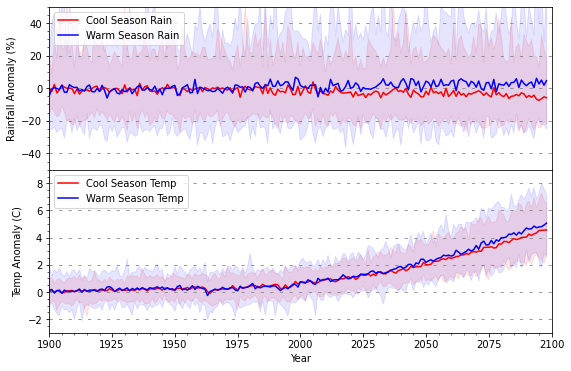

In [11]:
#Multi-model mean and min/max by season
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)

overlaidEmergePlot(domain(prXr).mean(['lon','lat']),)
plt.legend(['Cool Season Rain','Warm Season Rain'],loc='upper left')
plt.ylabel('Rainfall Anomaly (%)')
plt.xlim([1900,2100])
plt.ylim([-50,50])
plt.xticks([])
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplot(2,1,2)

overlaidEmergePlot(domain(tsXr).mean(['lon','lat']))
plt.legend(['Cool Season Temp','Warm Season Temp'],loc='upper left')
plt.xlim([1900,2100])
plt.ylim([-3,9])
plt.ylabel('Temp Anomaly (C)')
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplots_adjust(hspace=0)


plt.savefig('figures/cmip6RainTempTrends.pdf',bbox_inches='tight')

(-47.0, -20.0)

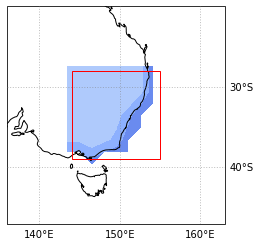

In [12]:
# sanity check that the domain looks like a good area

ax=plt.subplot(projection=ccrs.PlateCarree())
plotAnom(
    domain(
        (tsXr['Winter Temp'])
    ).mean(['model','year']),
    ax)

plt.xlim([136,163])
plt.ylim([-47,-20])

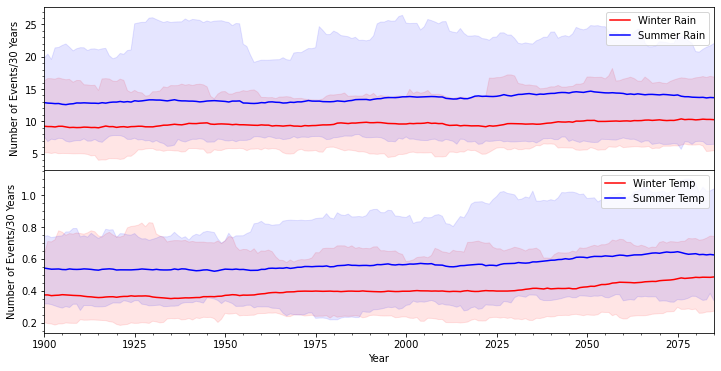

In [13]:
#multi model mean of Rolling 30 year std, by season
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)

overlaidEmergePlot(
        domain(prXr).mean(['lon','lat']).rolling(year=30,min_periods=15,center=True).std('year'),
)
plt.xlim([1900,2085])
plt.legend()
plt.xticks([])

plt.subplot(2,1,2)

overlaidEmergePlot(
    domain(detrendTsXr).mean(['lon','lat']).rolling(year=30,min_periods=15,center=True).std('year')
)
plt.xlim([1900,2085])
plt.legend()

plt.subplots_adjust(hspace=0)




<xarray.DataArray 'Winter Rain' ()>
array(31)

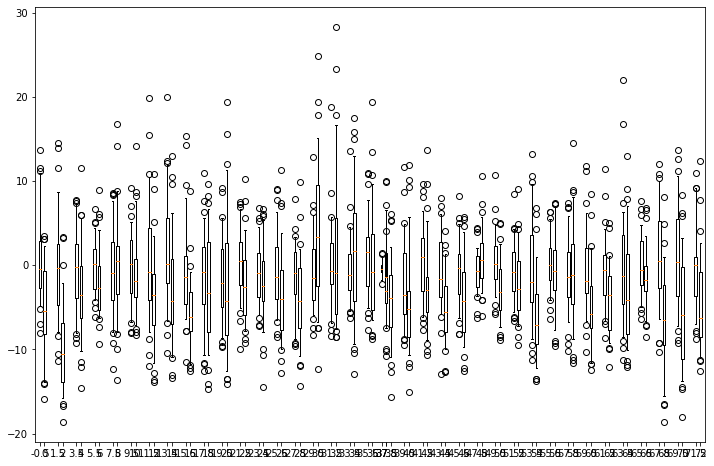

In [14]:
#box plots of historical and future win rain averages
plotData=prXr['Winter Rain'].mean(['lon','lat'])

plt.figure(figsize=(12,8))

plt.boxplot(
    [
        plotData.sel(year=slice(1950,1999), model=model).values
        for model in plotData.model.values
    ],
    whis=(5,95),
    positions=[2*i-0.5 for i in range(0,37)],
    widths=0.3,
)

plt.boxplot(
    plotData.sel(year=slice(1950,1999)).mean('year'), 
    positions=[(len(plotData.model.values))],
)

plt.boxplot(
    [
        plotData.sel(year=slice(2050,2099), model=model).values
        for model in plotData.model.values
    ],
    whis=(5,95),
    positions=[2*i for i in range(0,37)],
    widths=0.3,
)

plt.boxplot(
    plotData.sel(year=slice(2050,2099)).mean('year'), 
    positions=[(len(plotData.model.values))+0.5],
)

#junk=plt.xticks(ticks=range(0,37), labels=[*plotData.model.values])

((plotData.sel(year=slice(1950,1999)).mean('year'))>(plotData.sel(year=slice(2050,2099)).mean('year'))).sum()

<xarray.DataArray 'Winter Rain' ()>
array(31)

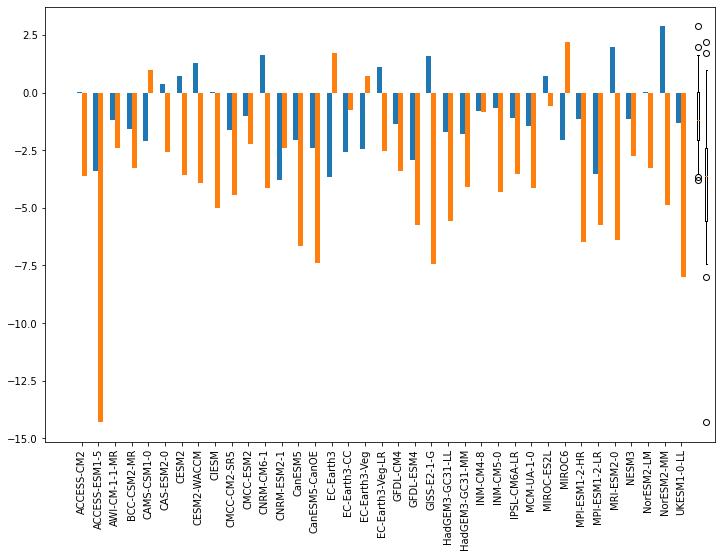

In [15]:
#historical and future winter rain means across the modelset
plotData=domain(prXr)['Winter Rain'].mean(['lon','lat'])

plt.figure(figsize=(12,8))

plt.bar(
    plotData.model.values, 
    plotData.sel(year=slice(1950,1999)).mean('year'),
    width=-0.3,
    align='edge'
)
junk=plt.xticks(rotation=90)
junk,models=plt.xticks()

plt.boxplot(
    plotData.sel(year=slice(1950,1999)).mean('year'), 
    positions=[(len(plotData.model.values))],
    whis=(5,95)
)

plt.bar(
    plotData.model, 
    plotData.sel(year=slice(2050,2099)).mean('year'),
    width=0.3,
    align='edge'
)

plt.boxplot(
    plotData.sel(year=slice(2050,2099)).mean('year'), 
    positions=[(len(plotData.model.values))+0.5],
    whis=(5,95)
)

junk=plt.xticks(ticks=range(0,37), labels=[*plotData.model.values])

((plotData.sel(year=slice(1950,1999)).mean('year'))>(plotData.sel(year=slice(2050,2099)).mean('year'))).sum()

<xarray.DataArray 'Summer Rain' ()>
array(27)

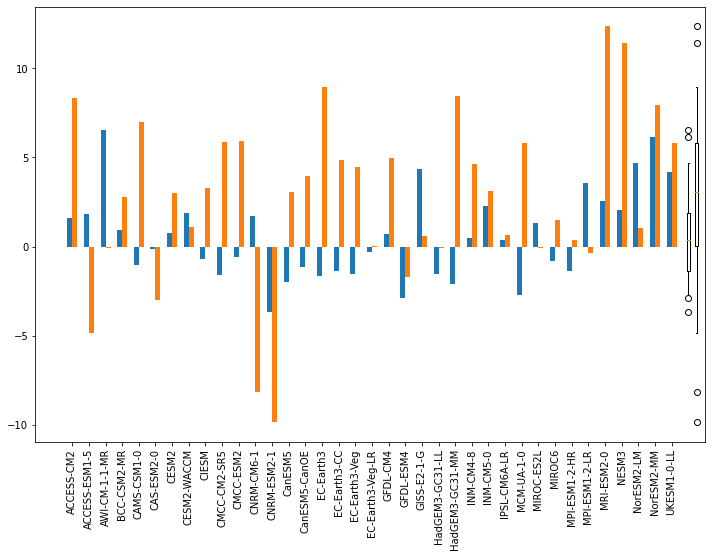

In [16]:
#historical and future summer rain means across the modelset

plotData=domain(prXr)['Summer Rain'].mean(['lon','lat'])

plt.figure(figsize=(12,8))

plt.bar(
    plotData.model.values, 
    plotData.sel(year=slice(1950,1999)).mean('year'),
    width=-0.3,
    align='edge'
)
junk=plt.xticks(rotation=90)
junk,models=plt.xticks()

plt.boxplot(
    plotData.sel(year=slice(1950,1999)).mean('year'), 
    positions=[(len(plotData.model.values))],
    whis=(5,95)
)

plt.bar(
    plotData.model, 
    plotData.sel(year=slice(2050,2099)).mean('year'),
    width=0.3,
    align='edge'
)

plt.boxplot(
    plotData.sel(year=slice(2050,2099)).mean('year'), 
    positions=[(len(plotData.model.values))+0.5],
    whis=(5,95)
)

junk=plt.xticks(ticks=range(0,37), labels=[*plotData.model.values])

((plotData.sel(year=slice(1950,1999)).mean('year'))<(plotData.sel(year=slice(2050,2099)).mean('year'))).sum()

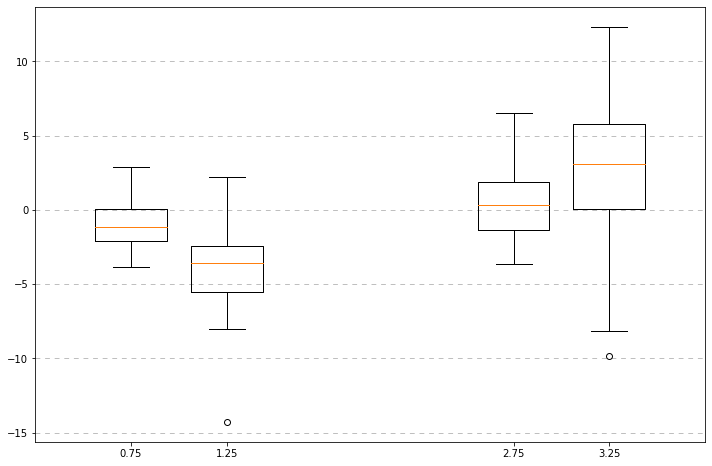

In [17]:
#box plots of the multi-model mean of winter/summer historical/future averages
plt.figure(figsize=(12,8))

plotData=domain(prXr).mean(['lon','lat'])

junk = plt.boxplot(
    [
        plotData['Winter Rain'].sel(year=slice(1950,1999)).mean('year'),
        plotData['Winter Rain'].sel(year=slice(2050,2099)).mean('year'), 
        plotData['Summer Rain'].sel(year=slice(1950,1999)).mean('year'),
        plotData['Summer Rain'].sel(year=slice(2050,2099)).mean('year'), 
    ],
    positions=[0.75,1.25, 2.75,3.25],
)

plt.grid(axis='y', dashes=(6,6))

# Spatial mean state changes

Trends in rainfall anomalies for all models

In [18]:
%run helpers/impactPlots.ipynb

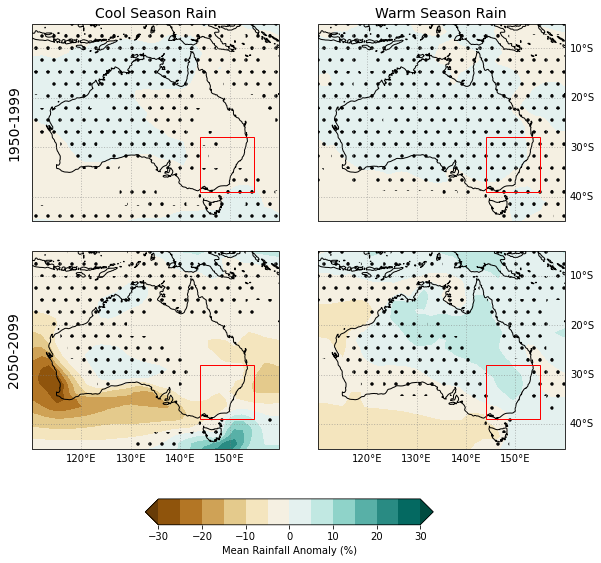

In [19]:
fig=plt.figure(figsize=(10,12))
import matplotlib.cm as cm
import matplotlib.colorbar as cb

#first is 1950-1999 winter rain
ax=fig.add_subplot(3, 2,  1, projection=ccrs.PlateCarree())
cs,gl=plotAnom(
    prXr['Winter Rain'].sel(year=slice(1950,1999)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Winter Rain'].sel(year=slice(1950,1999)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])
gl.bottom_labels=False
gl.right_labels=False

#first col heading
plt.title('Cool Season Rain',{'fontsize':14})

#first row needs a label
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    '1950-1999',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)


#2050-2099 winter rain
ax=fig.add_subplot(3, 2,  3, projection=ccrs.PlateCarree())
cs,gl=plotAnom(
    prXr['Winter Rain'].sel(year=slice(2050,2099)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Winter Rain'].sel(year=slice(2050,2099)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])
gl.right_labels=False


#second row needs a label
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    '2050-2099',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)

#1950-1999 summer rain
ax=fig.add_subplot(3, 2,  2, projection=ccrs.PlateCarree())
cs,gl=plotAnom(
    prXr['Summer Rain'].sel(year=slice(1950,1999)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Summer Rain'].sel(year=slice(1950,1999)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])
gl.bottom_labels=False

#second col heading
plt.title('Warm Season Rain',{'fontsize':14})

#2050-2099 summer rain
ax=fig.add_subplot(3, 2,  4, projection=ccrs.PlateCarree())
cs,gl=plotAnom(
    prXr['Summer Rain'].sel(year=slice(2050,2099)).mean(['model','year']),
    ax, 
)
plotStipling(
    prXr['Summer Rain'].sel(year=slice(2050,2099)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])

# add some space between rows
plt.subplots_adjust(hspace=0.15, wspace=0.05)

# add a colour bar
ax=fig.add_axes([0.3,0.3,0.4,0.03])
cbar=plt.colorbar(
    cm.ScalarMappable(cs.norm,cs.cmap),
    orientation='horizontal', 
    cax=ax, 
    extend='both', 
    boundaries=cs.get_array(), 
    label = 'Mean Rainfall Anomaly (%)',
)


plt.savefig('figures/cmip6RainSpatialTrends.pdf', bbox_inches='tight')
    

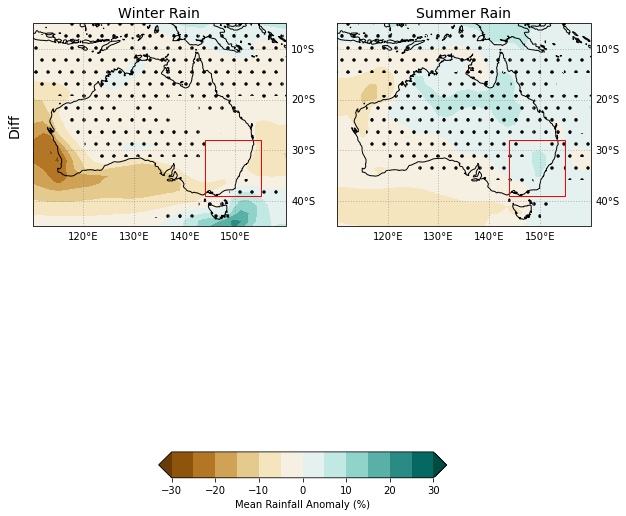

In [20]:
fig=plt.figure(figsize=(10,12))
import matplotlib.cm as cm
import matplotlib.colorbar as cb

plotData=prXr.sel(year=slice(2050,2099)).mean(['year'])-prXr.sel(year=slice(1950,1999)).mean(['year'])

#make a sub plot
ax=fig.add_subplot(
    2, 2,  1, projection=ccrs.PlateCarree()
)
plotAnom(
    plotData['Winter Rain'].mean(['model']),
    ax, 
)
plotStipling(
    plotData['Winter Rain'],
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    'Diff',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)
plt.title('Winter Rain',{'fontsize':14})

ax=fig.add_subplot(
    2, 2,  2, projection=ccrs.PlateCarree()
)
cs,gl=plotAnom(
    plotData['Summer Rain'].mean(['model']),
    ax, 
)
plotStipling(
    plotData['Summer Rain'],
    ax, 
)

plt.ylim([-45,-5])
plt.xlim([110,160])
plt.title('Summer Rain',{'fontsize':14})


ax=fig.add_axes([0.3,0.3,0.4,0.03])
cbar=plt.colorbar(
    cm.ScalarMappable(cs.norm,cs.cmap),
    orientation='horizontal', 
    cax=ax, 
    extend='both', 
    boundaries=cs.get_array(), 
    label = 'Mean Rainfall Anomaly (%)',
)


    

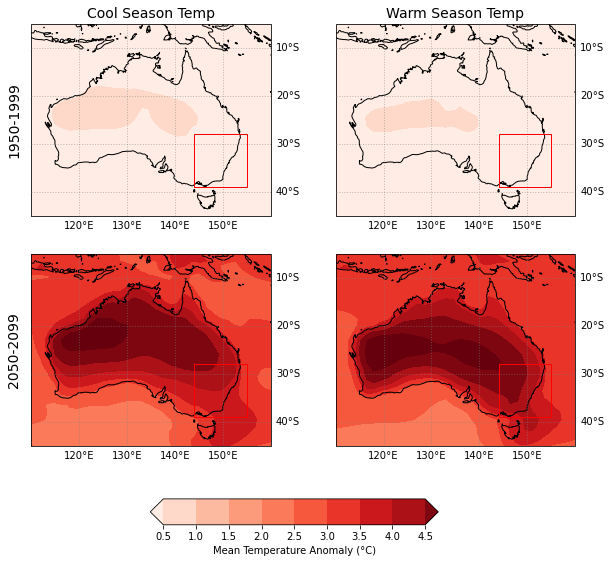

In [30]:
%run helpers/impactPlots.ipynb
fig=plt.figure(figsize=(10,12))
import matplotlib.cm as cm
import matplotlib.colorbar as cb

#first is 1950-1999 winter rain
ax=fig.add_subplot(3, 2,  1, projection=ccrs.PlateCarree())
plotAnom(
    tsXr['Winter Temp'].sel(year=slice(1950,1999)).mean(['model','year']),
    ax, 
)
plotStipling(
    tsXr['Winter Temp'].sel(year=slice(1950,1999)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])

#first col heading
plt.title('Cool Season Temp',{'fontsize':14})

#first row needs a label
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    '1950-1999',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)


#2050-2099 winter rain
ax=fig.add_subplot(3, 2,  3, projection=ccrs.PlateCarree())
plotAnom(
    tsXr['Winter Temp'].sel(year=slice(2050,2099)).mean(['model','year']),
    ax, 
)
plotStipling(
    tsXr['Winter Temp'].sel(year=slice(2050,2099)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])

#second row needs a label
ax.text(
    -0.1, 0.5,  #xy relative to bottom left of axis
    '2050-2099',
    rotation='vertical', 
    transform=ax.transAxes, 
    verticalalignment='center', 
    fontsize=14
)

#1950-1999 summer rain
ax=fig.add_subplot(3, 2,  2, projection=ccrs.PlateCarree())
plotAnom(
    tsXr['Summer Temp'].sel(year=slice(1950,1999)).mean(['model','year']),
    ax, 
)
plotStipling(
    tsXr['Summer Temp'].sel(year=slice(1950,1999)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])

#second col heading
plt.title('Warm Season Temp',{'fontsize':14})

#2050-2099 summer rain
ax=fig.add_subplot(3, 2,  4, projection=ccrs.PlateCarree())
cs,gl=plotAnom(
    tsXr['Summer Temp'].sel(year=slice(2050,2099)).mean(['model','year']),
    ax, 
)
plotStipling(
    tsXr['Summer Temp'].sel(year=slice(2050,2099)).mean(['year']),
    ax, 
)
plt.ylim([-45,-5])
plt.xlim([110,160])

# add a colour bar
ax=fig.add_axes([0.3,0.3,0.4,0.03])
cbar=plt.colorbar(
    cm.ScalarMappable(cs.norm,cs.cmap),
    orientation='horizontal', 
    cax=ax, 
    extend='both', 
    boundaries=cs.get_array(), 
    label = 'Mean Temperature Anomaly (°C)',
)

plt.savefig('figures/cmip6TempSpatialTrends.pdf', bbox_inches='tight')


# Single event impacts

In [22]:
#temperature gets detrended
trendXr=tsXr.rolling(year=31,min_periods=15,center=True).mean('year')
detrendTsXr=(tsXr-trendXr)

In [23]:
eventsList=['ecCombined','dmi','samWinter','samSummer']
maskXr = (fireEventsXr[eventsList]==1)
everythingXr=(fireEventsXr['nino34'].isnull()==False)
everythingXr.name='everything'

Fire:pos
winter


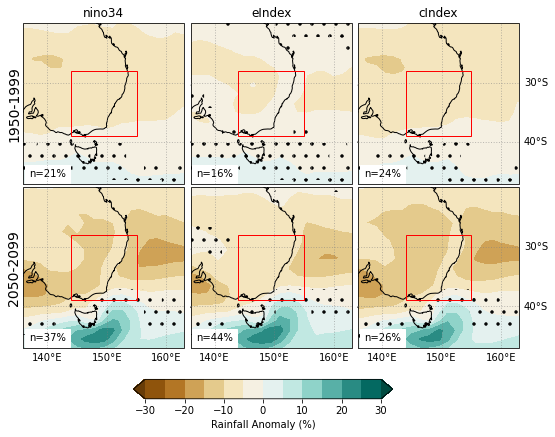

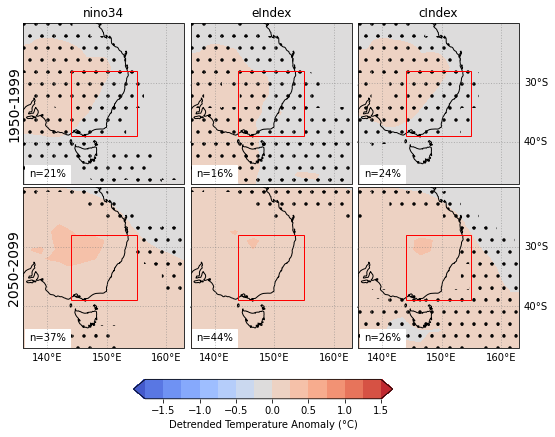

summer


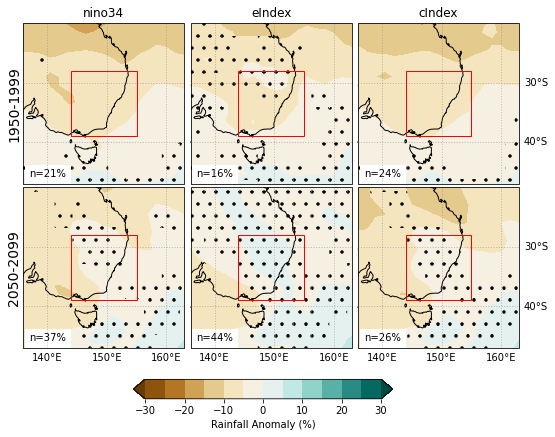

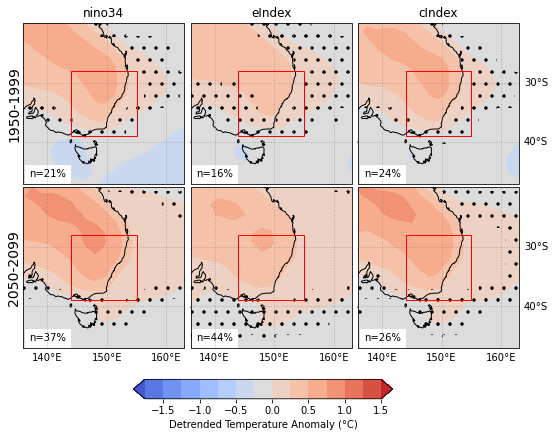

Fire:neg
winter


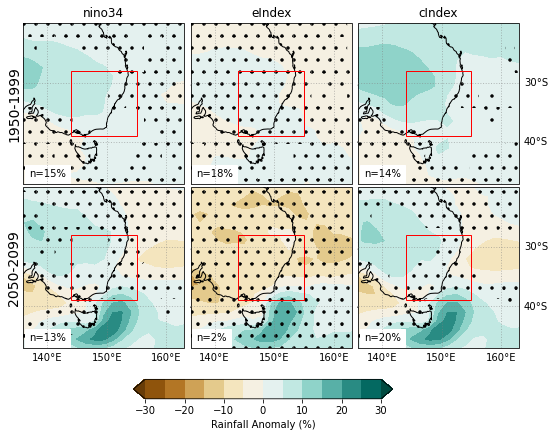

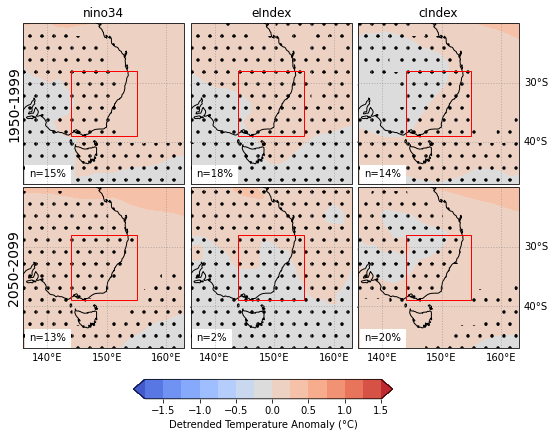

summer


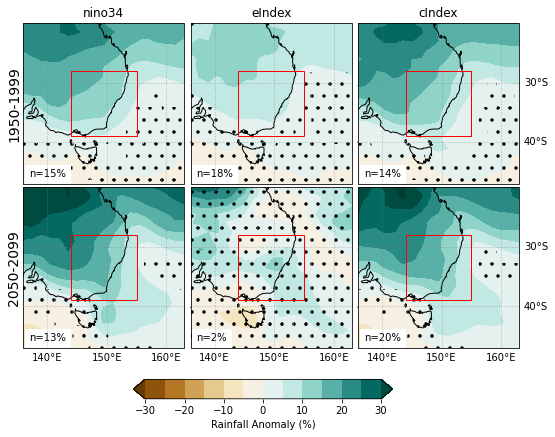

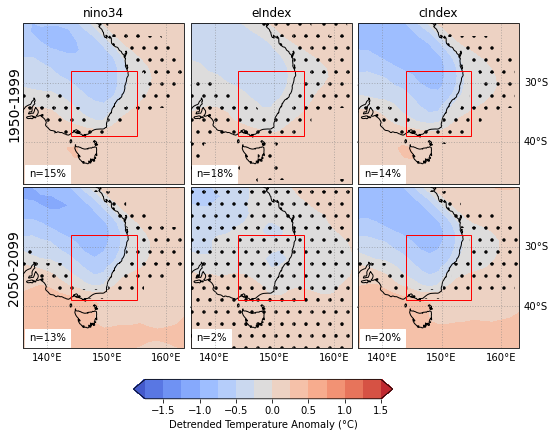

In [31]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            maskXr.sel(fire=iFire,drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        plt.show()
        
        axs=multiPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            maskXr.sel(fire=iFire,drop=True),
            eventsList,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        plt.show()

# ENSO index comparison

In [25]:
#eventsList=['ecCombined','nino34', 'eIndex','nino3','cIndex','nino4']
eventsList=['nino34', 'eIndex','cIndex']
maskXr = (fireEventsXr[eventsList]==1)
everythingXr=(fireEventsXr['nino34'].isnull()==False)
everythingXr.name='everything'

Fire:pos
winter


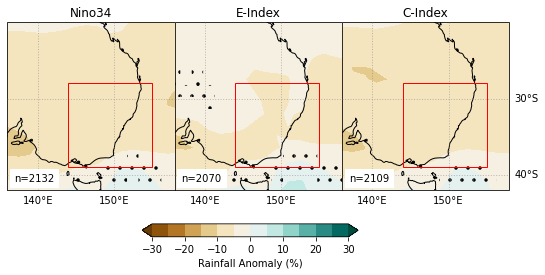

summer


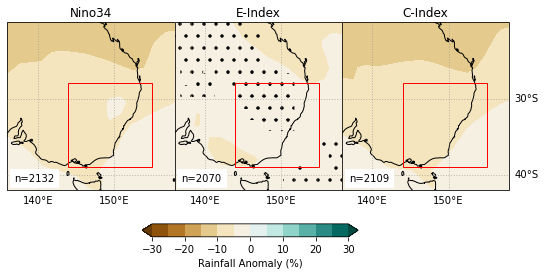

Fire:neg
winter


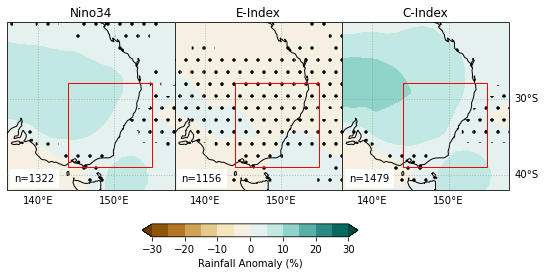

summer


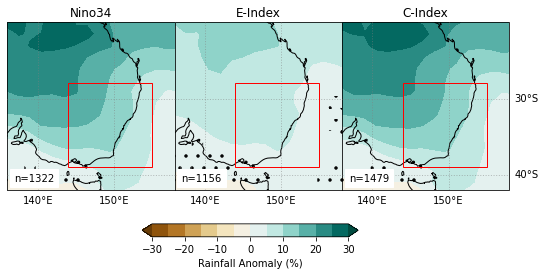

In [26]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            maskXr.sel(fire=iFire,drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('Nino34')
        axs[1].set_title('E-Index')
        axs[2].set_title('C-Index')
        plt.show()
        
        #axs=indexPlotter(
        #    detrendTsXr[iSeason.capitalize()+' Temp'],
        #    maskXr.sel(fire=iFire,drop=True),
        #    eventsList,
        #    cbarLabel='Detrended Temperature Anomaly (°C)'
        #)
        #axs[0].set_title('ENSO+IOD')
        #axs[1].set_title('ENSO+SAM')
        #axs[2].set_title('IOD+SAM')
        #axs[3].set_title('All3')
        #plt.show()

ACCESS-CM2
Fire:pos


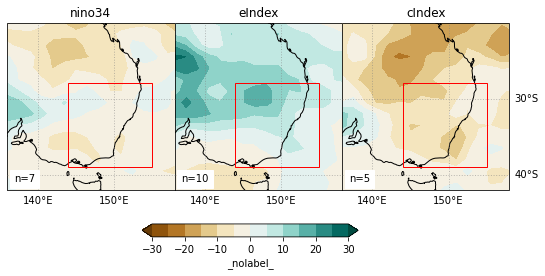

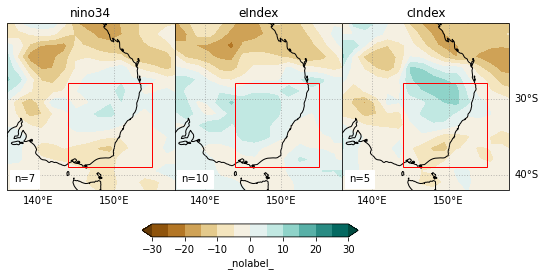

ACCESS-ESM1-5
Fire:pos


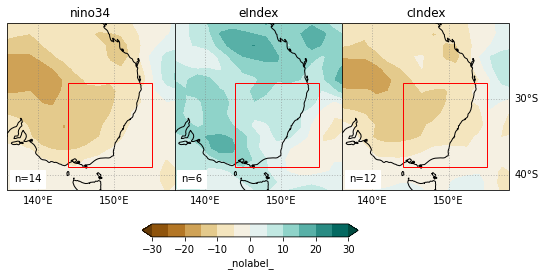

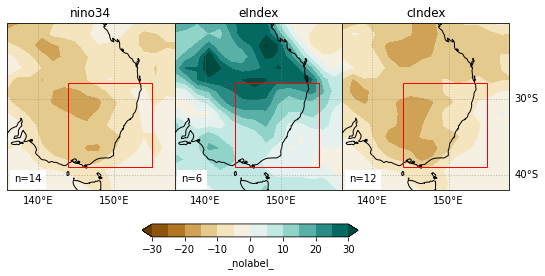

AWI-CM-1-1-MR
Fire:pos


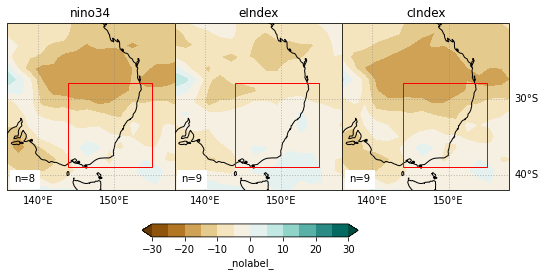

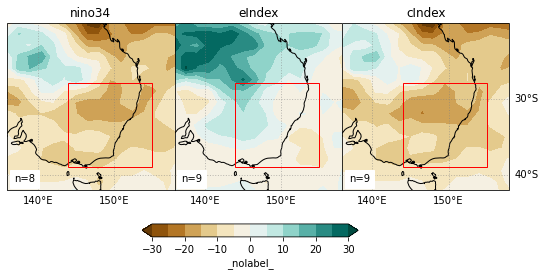

BCC-CSM2-MR
Fire:pos


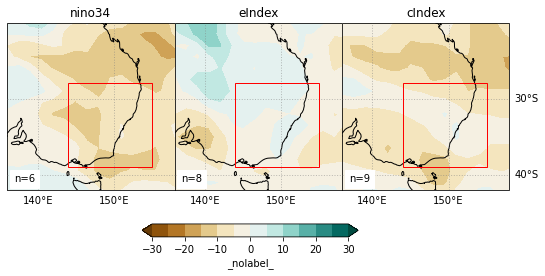

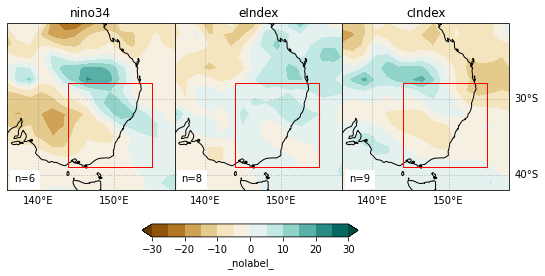

CAMS-CSM1-0
Fire:pos


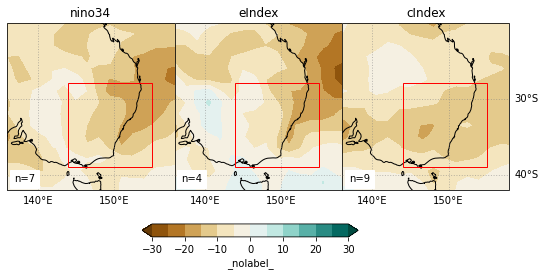

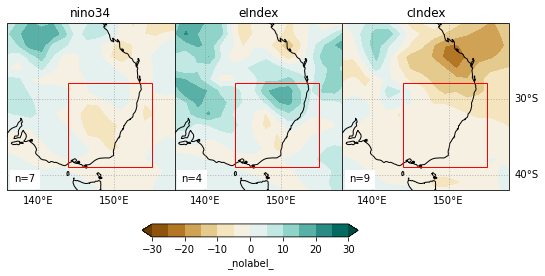

CAS-ESM2-0
Fire:pos


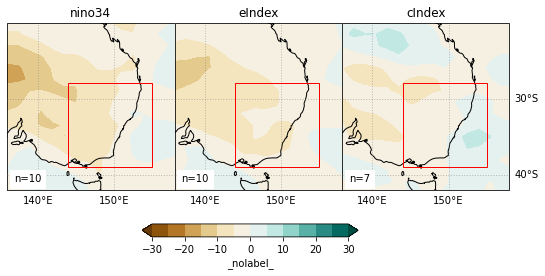

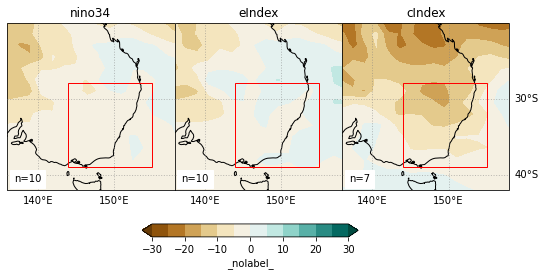

CESM2
Fire:pos


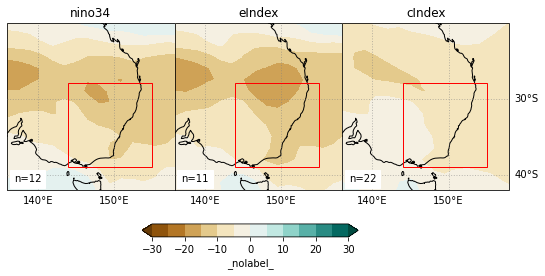

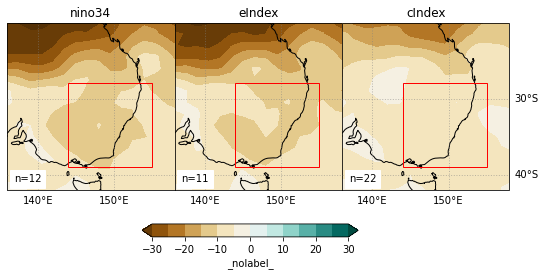

CESM2-WACCM
Fire:pos


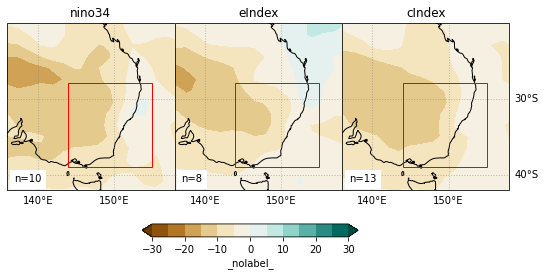

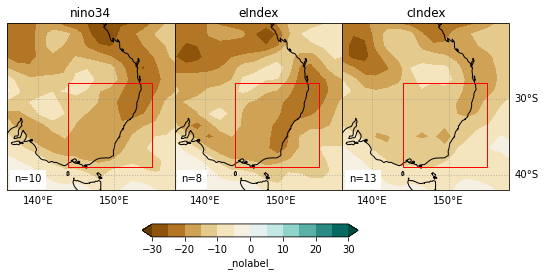

CIESM
Fire:pos


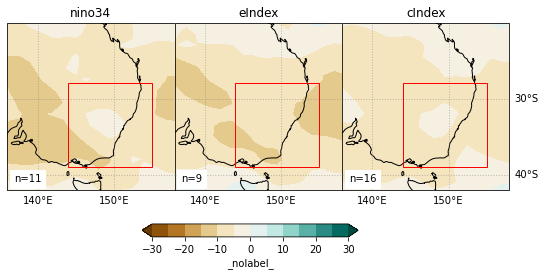

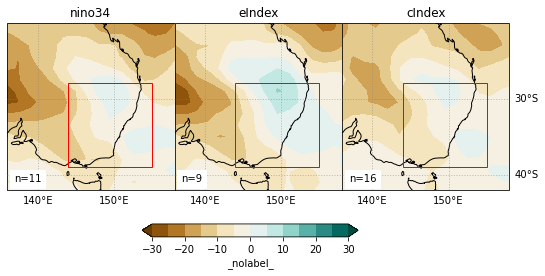

CMCC-CM2-SR5
Fire:pos


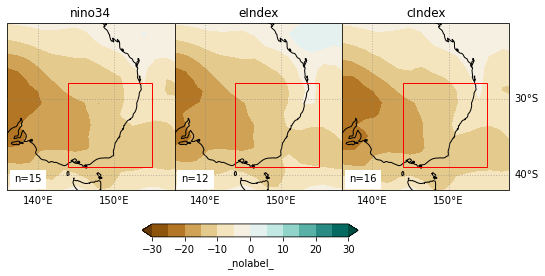

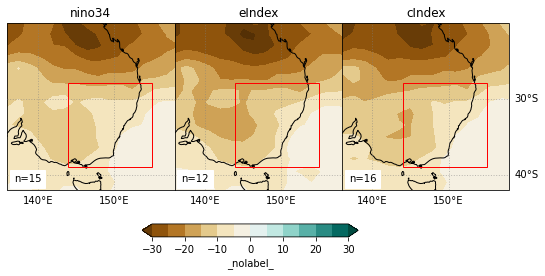

CMCC-ESM2
Fire:pos


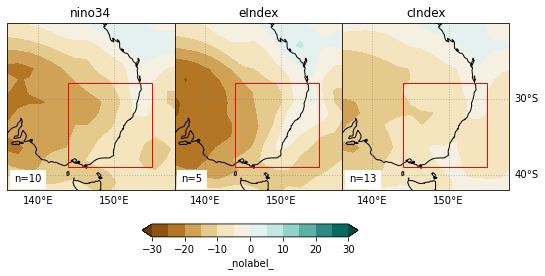

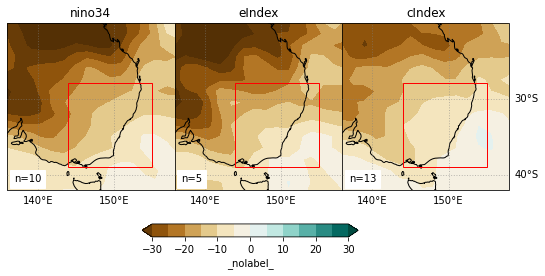

CNRM-CM6-1
Fire:pos


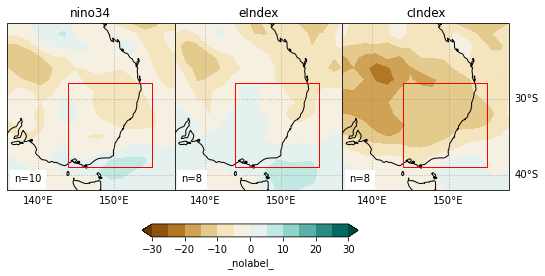

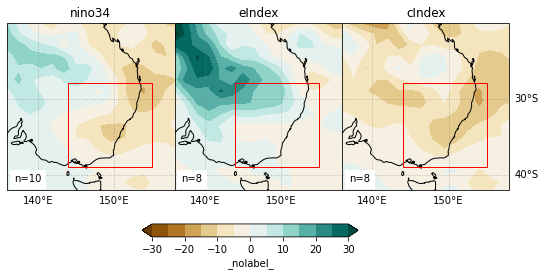

CNRM-ESM2-1
Fire:pos


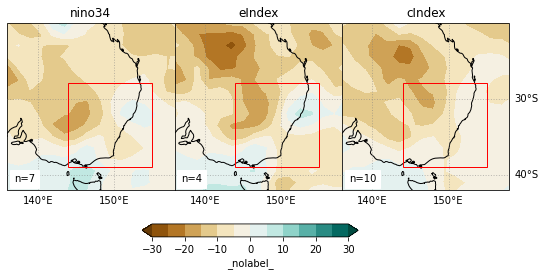

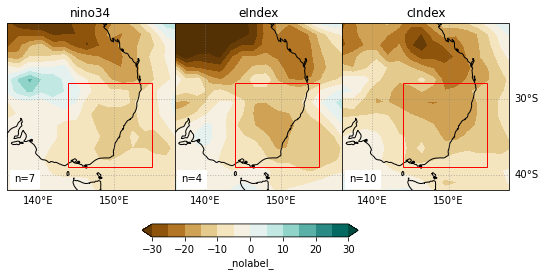

CanESM5
Fire:pos


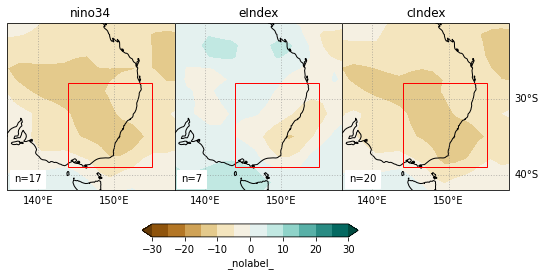

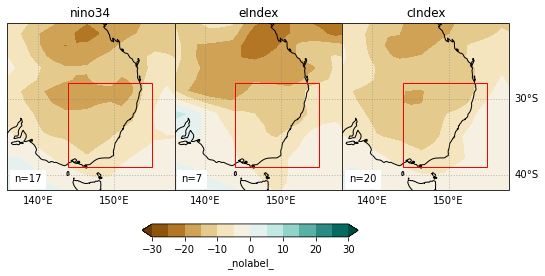

CanESM5-CanOE
Fire:pos


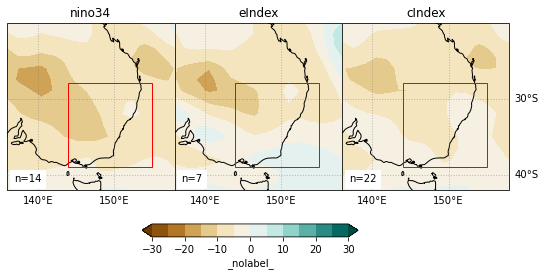

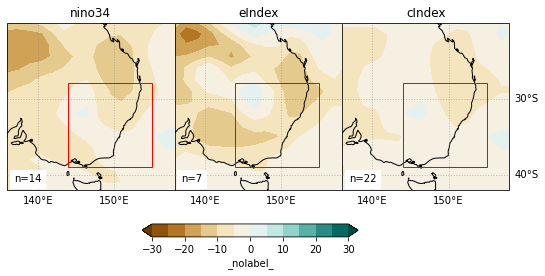

EC-Earth3
Fire:pos


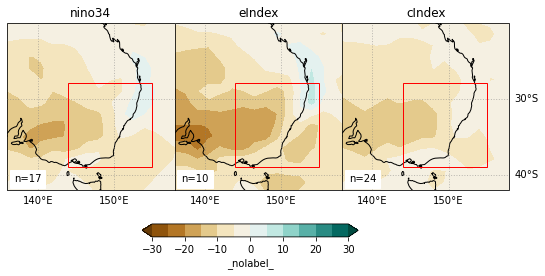

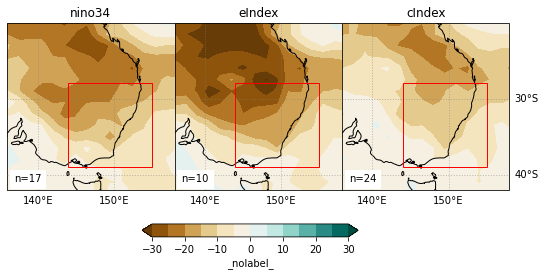

EC-Earth3-CC
Fire:pos


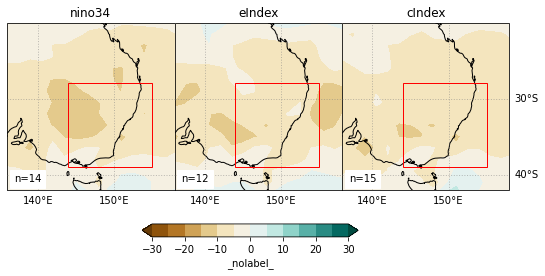

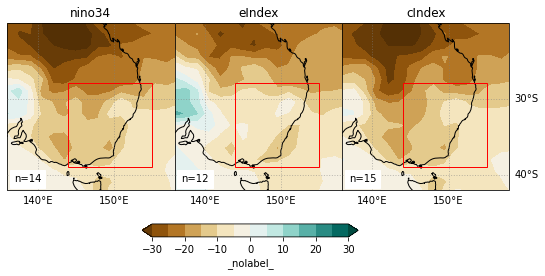

EC-Earth3-Veg
Fire:pos


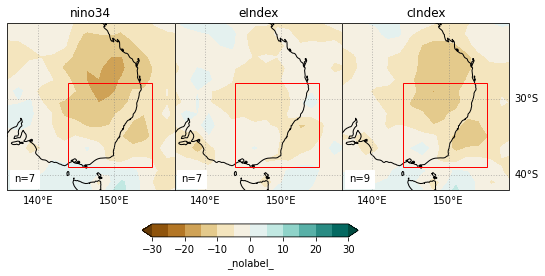

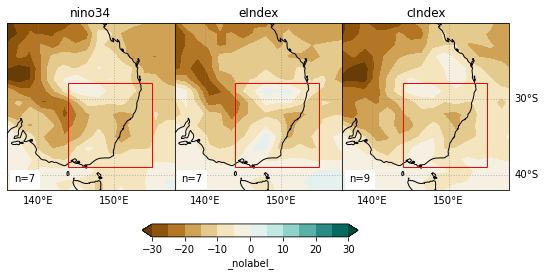

EC-Earth3-Veg-LR
Fire:pos


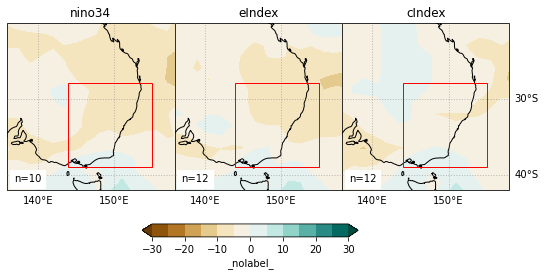

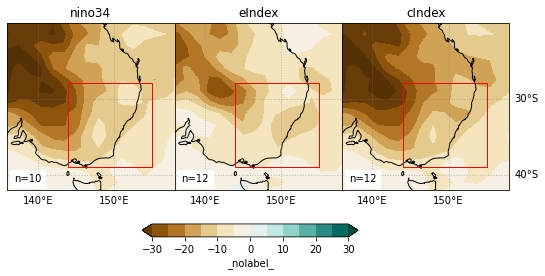

GFDL-CM4
Fire:pos


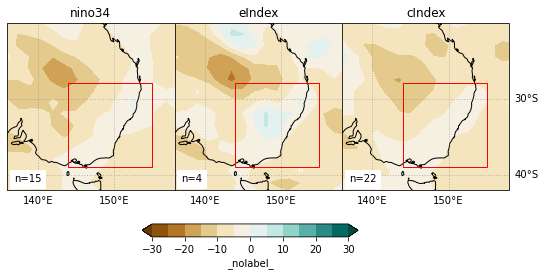

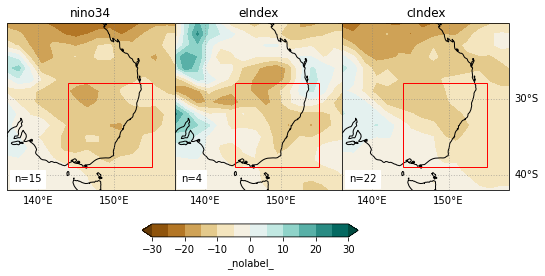

GFDL-ESM4
Fire:pos


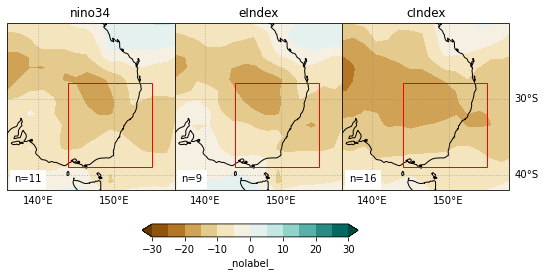

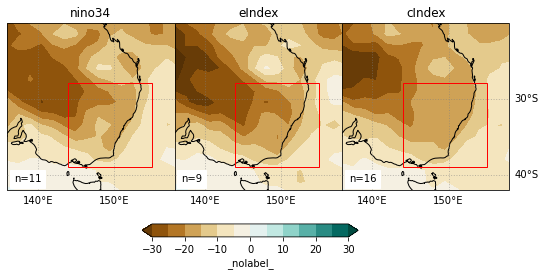

GISS-E2-1-G
Fire:pos


KeyError: 'GISS-E2-1-G'

In [27]:
for iModel in prXr.model.values:
    print(iModel)
    for iFire in ['pos']:#,'neg']:
        print('Fire:'+iFire)
        for iSeason in ['winter',
            'summer']:
            #print('1950-1999')
            indexPlotter(
                prXr[iSeason.capitalize()+' Rain'].sel(model=iModel),
                maskXr.sel(fire=iFire,model=iModel,year=slice(1950,1999),drop=True), 
                eventsList,
                stipling=False
            )
            plt.show()
            #print('2050-2099')
            #indexPlotter(
            #    prXr[iSeason.capitalize()+' Rain'].sel(model=iModel),
            #    maskXr.sel(fire=iFire,model=iModel,year=slice(2050,2099),drop=True), 
            #    eventsList,
            #    stipling=False
            #)
            plt.show()
            #indexPlotter(
            #    detrendXr['ts'+iSeason.capitalize()].sel(model=iModel),
            #    maskXr.sel(fire=iFire,model=iModel,drop=True), 
            #    eventsList,
            #)
            #plt.show()

# Model comparisons

In [ ]:
#eventsList=['ecCombined','nino34', 'eIndex','nino3','cIndex','nino4']
eventsList=['eIndex','cIndex', 'dmi','samSummer']
maskXr = (fireEventsXr[eventsList]==1)
everythingXr=(fireEventsXr['nino34'].isnull()==False)
everythingXr.name='everything'

In [ ]:
eventAnoms.sel(fire='pos')


In [ ]:
eventAnoms

In [ ]:
(eventAnoms['cIndex'].values)>0

In [ ]:
CWetter=dict()
ENeg=dict()
CNeg=dict()

for iFire in ['pos','neg']:
    CWetter['winter']=list()
    CWetter['summer']=list()
    ENeg['winter']=list()
    ENeg['summer']=list()
    CNeg['winter']=list()
    CNeg['summer']=list()
    for iModel in prXr.model.values:
        for iSeason in ['winter','summer']:
            eventAnoms=dict()
            for iIndex in ['eIndex','cIndex' ]:
                eventAnoms[iIndex]=domain(
                    prXr[iSeason.capitalize()+' Rain'].where(
                        maskXr[iIndex].sel(year=slice(1950,1999),fire=iFire,model=iModel,drop=True)
                        )
                    ).sel(model=iModel,drop=True).mean(['lat','lon','year'])
            CWetter[iSeason].append((eventAnoms['cIndex'].values)>(eventAnoms['eIndex'].values))
            ENeg[iSeason].append((eventAnoms['eIndex'].values)<0)
            CNeg[iSeason].append((eventAnoms['cIndex'].values)<0)

    print(sum(CWetter['winter']))
    print(sum(CWetter['summer']))
    print(sum(ENeg['winter']))
    print(sum(ENeg['summer']))
    print(sum(CNeg['winter']))
    print(sum(CNeg['summer']))

In [ ]:
for iModel in prXr.model.values:
    print(iModel)
    for iFire in ['pos']:#,'neg']:
        print('Fire:'+iFire)
        for iSeason in [#'winter',
            'summer']:
            print('1950-1999')
            indexPlotter(
                prXr[iSeason.capitalize()+' Rain'].sel(model=iModel),
                maskXr.sel(fire=iFire,model=iModel,year=slice(1950,1999),drop=True), 
                eventsList,
                stipling=False
            )
            plt.show()
            #print('2050-2099')
            #indexPlotter(
            #    prXr[iSeason.capitalize()+' Rain'].sel(model=iModel),
            #    maskXr.sel(fire=iFire,model=iModel,year=slice(2050,2099),drop=True), 
            #    eventsList,
            #    stipling=False
            #)
            #plt.show()
            #indexPlotter(
            #    detrendXr['ts'+iSeason.capitalize()].sel(model=iModel),
            #    maskXr.sel(fire=iFire,model=iModel,drop=True), 
            #    eventsList,
            #)
            #plt.show()